In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn.metrics import silhouette_score

In [2]:
dataset = pd.read_csv('Run200_Wave_0_1.txt', sep=' ', header=None, skipinitialspace=True)
dataset = dataset.drop([0, 1, 2, 3, 504], axis=1)
dataset.columns = list(range(500))
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,14820,14823,14824,14822,14818,14820,14824,14822,14820,14820,...,14828,14822,14815,14815,14817,14819,14820,14822,14820,14819
1,14820,14822,14820,14826,14824,14822,14820,14822,14823,14821,...,14828,14817,14824,14822,14824,14819,14820,14819,14822,14820
2,14820,14820,14822,14825,14820,14824,14824,14819,14823,14824,...,14820,14821,14820,14820,14818,14821,14823,14820,14820,14821
3,14828,14822,14818,14824,14824,14822,14820,14822,14824,14820,...,14824,14826,14822,14821,14820,14828,14820,14822,14823,14822
4,14823,14815,14823,14821,14827,14820,14823,14824,14816,14821,...,14820,14820,14823,14828,14824,14820,14824,14824,14822,14825


In [3]:
dataset = (2**14) - dataset - 1560

Text(0, 0.5, 'bit ADC')

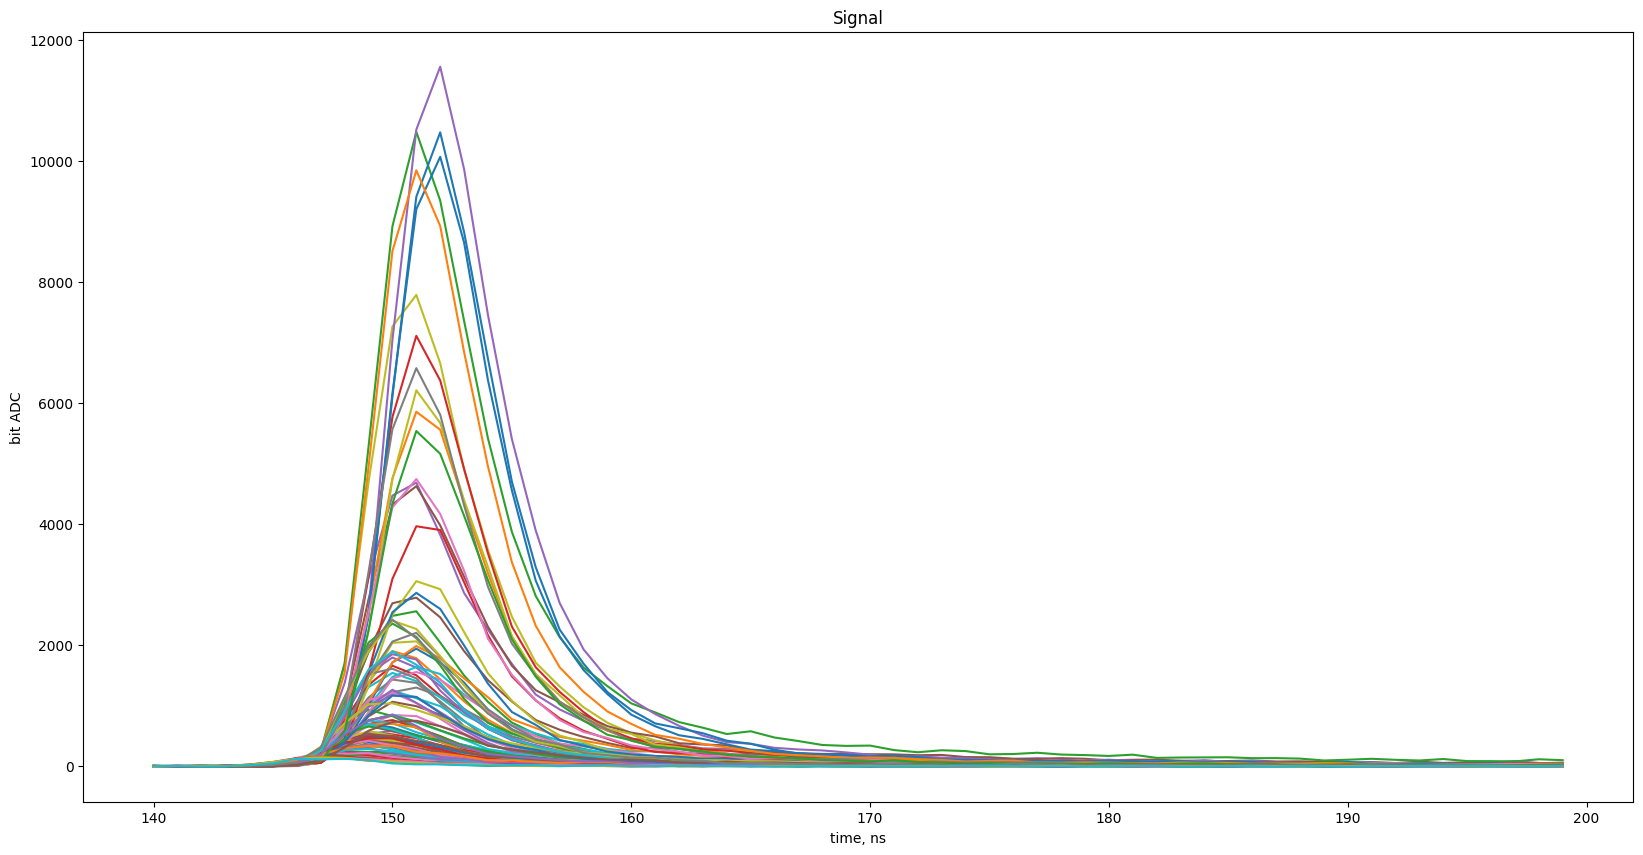

In [4]:
N=range(0,100)
ax = (dataset.T[N])[140:200].plot(title='Signal', legend=None, figsize=(20,10))
ax.set_xlabel("time, ns")
ax.set_ylabel("bit ADC")

In [5]:
amplitudes = []
volumes = []
psd_values = []
tau_values = []
for i, row in dataset.iterrows():
    signal = row.values.astype(float)

    signal -= np.mean(signal[:50])
    noise = 3 * np.std(signal[:50])

    max_index = np.argmax(signal)
    end_index = len(signal)
    for i in range(max_index, len(signal)):
        if signal[i] < noise:
            end_index = i
            break

    signal = signal[max_index:end_index]

    amplitudes.append(np.abs(np.max(signal) - np.min(signal)))

    volumes.append(np.trapz(signal))

    psd_values.append((volumes[-1] - np.trapz(signal[:5])) / volumes[-1])
    try:
        current_max = signal[0]
        threshold_level = current_max * 0.6
        
        start_fit_idx = 0
        for k in range(len(signal)):
            if signal[k] < threshold_level:
                start_fit_idx = k
                break
        
        y_data = signal[start_fit_idx:]
        x_data = np.arange(start_fit_idx, len(signal))
        
        valid_mask = y_data > 0
        y_data = y_data[valid_mask]
        x_data = x_data[valid_mask]

        tau = 0
        if len(y_data) > 4:
            slope, intercept = np.polyfit(x_data, np.log(y_data), 1)

            if slope < 0:
                tau = -1.0 / slope
                
        tau_values.append(tau)
        
    except Exception:
        tau_values.append(0)

amplitudes = np.array(amplitudes)
volumes = np.array(volumes)
psd_values = np.array(psd_values)
tau_values = np.array(tau_values)

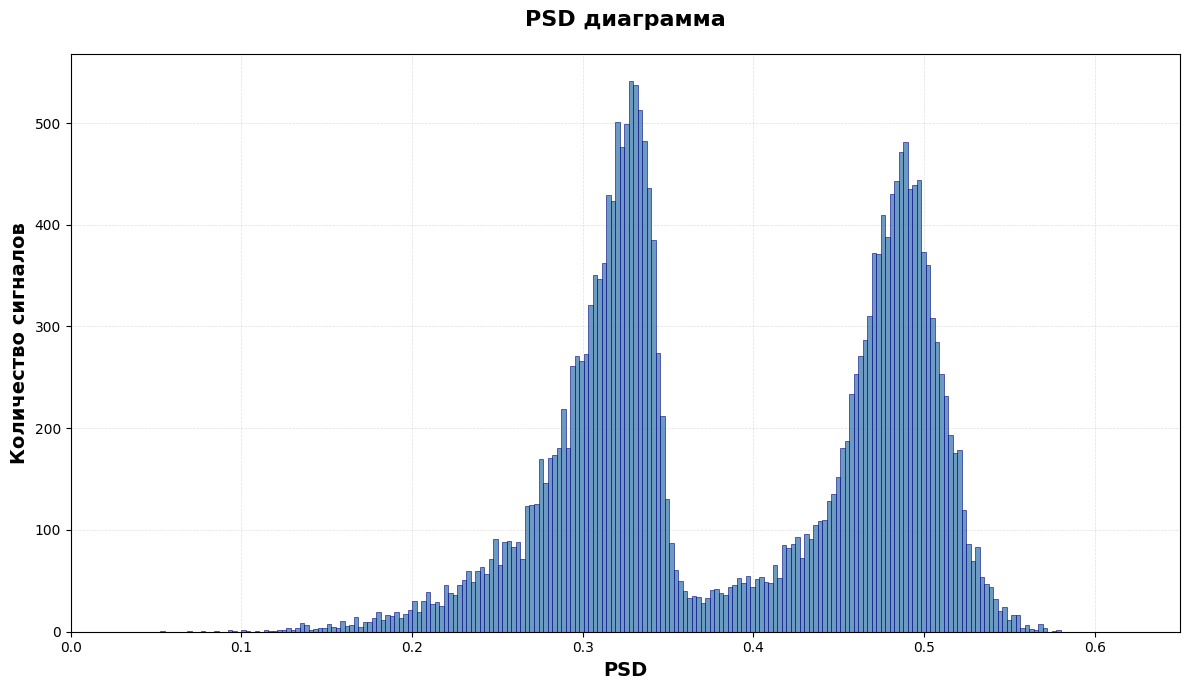

In [6]:
plt.figure(figsize=(12, 7))
plt.hist(psd_values, bins=200, alpha=0.8, color="steelblue", edgecolor="navy", linewidth=0.5)
plt.xlabel("PSD", fontsize=14, fontweight="bold")
plt.xlim(0, 0.65)
plt.ylabel("Количество сигналов", fontsize=14, fontweight="bold")
plt.title("PSD диаграмма", fontsize=16, fontweight="bold", pad=20)
plt.grid(True, alpha=0.4, linestyle="--", linewidth=0.5)
plt.gca().set_axisbelow(True)
plt.tight_layout()
plt.show()

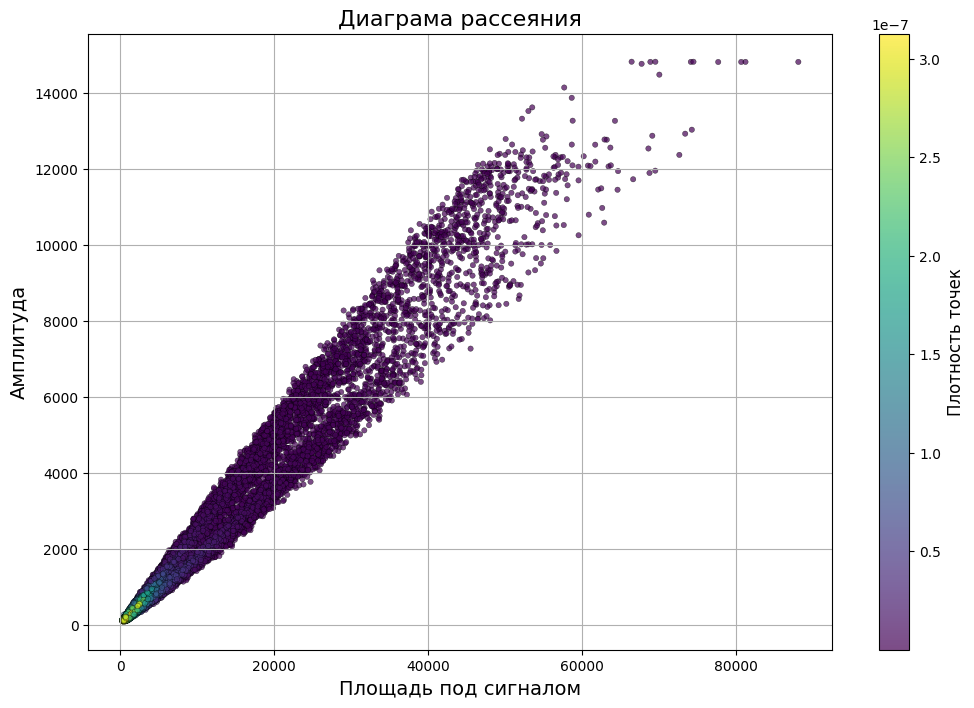

In [7]:
xy = np.vstack([volumes, amplitudes])
density = gaussian_kde(xy)(xy)

plt.figure(figsize=(12, 8))
scatterplot = plt.scatter(volumes, amplitudes, c=density, s=15, alpha=0.7, cmap="viridis", edgecolors="black", linewidths=0.3)
cbar = plt.colorbar(scatterplot)
cbar.set_label("Плотность точек", fontsize=12)
plt.xlabel('Площадь под сигналом', fontsize=14)
plt.ylabel('Амплитуда', fontsize=14)
plt.title('Диаграма рассеяния', fontsize=16)

plt.grid(True)
plt.show()

In [8]:
dataset["amplitude"] = amplitudes
dataset["volume"] = volumes
dataset["psd"] = psd_values

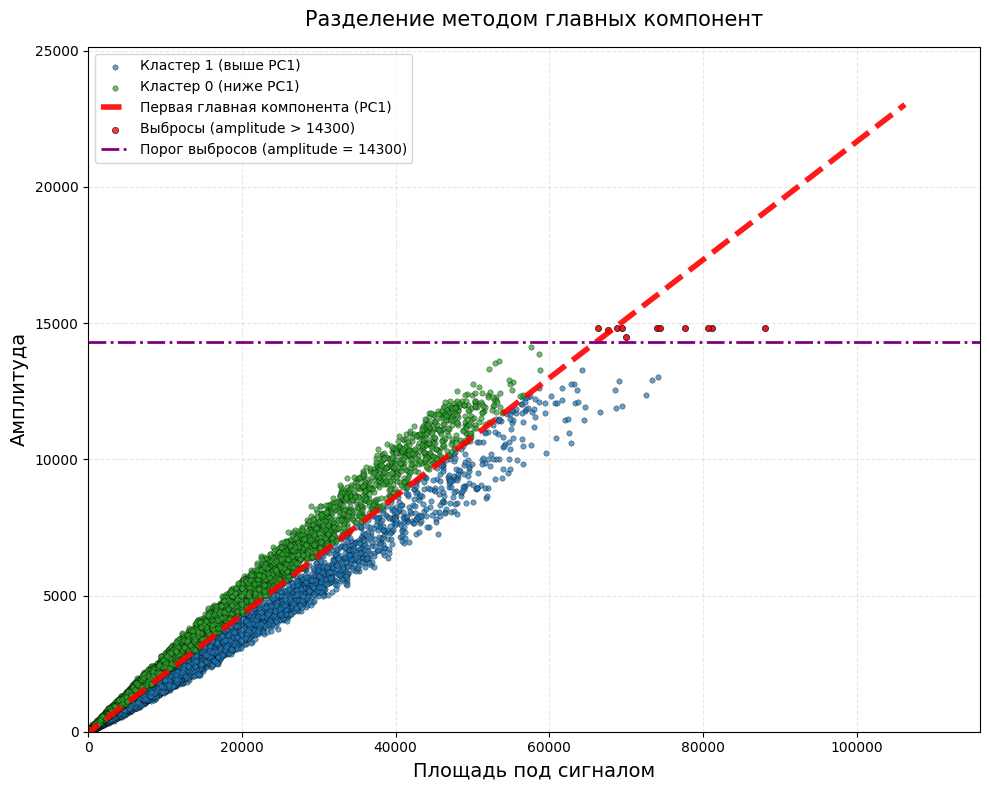

Коэффициент силуэта: 0.021860452813249994
Score на Kaggle: 0.79066


In [9]:
X = dataset[["volume", "amplitude"]].values
scaler = StandardScaler()
X_for_silhouette = scaler.fit_transform(X)

pca = PCA(n_components=1)
X_proj = pca.fit_transform(X)

center = X.mean(axis=0)
pc1 = pca.components_[0]

t = np.linspace(-1e5, 1e5, 2)
line = center + t[:, None] * pc1
x_line, y_line = line[:, 0], line[:, 1]

vectors = X - center
cross = vectors[:, 0] * pc1[1] - vectors[:, 1] * pc1[0]
above = cross > 0
below = cross < 0

plt.figure(figsize=(10, 8))

plt.scatter(X[above, 0], X[above, 1], c="tab:blue",  s=15, alpha=0.7,
            edgecolors="black", linewidths=0.3, label="Кластер 1 (выше PC1)")
plt.scatter(X[below, 0], X[below, 1], c="tab:green", s=15, alpha=0.7,
            edgecolors="black", linewidths=0.3, label="Кластер 0 (ниже PC1)")

plt.plot(x_line, y_line, "r--", linewidth=4, alpha=0.9, label="Первая главная компонента (PC1)")

amp_thr = 14300
outliers = dataset["amplitude"] > amp_thr
if outliers.any():
    plt.scatter(dataset.loc[outliers, "volume"], dataset.loc[outliers, "amplitude"],
                c="red", s=20, alpha=0.8, edgecolors="black", linewidths=0.5,
                label="Выбросы (amplitude > 14300)")

plt.axhline(y=amp_thr, color="purple", linestyle="-.", linewidth=2,
            label="Порог выбросов (amplitude = 14300)")

plt.xlabel("Площадь под сигналом", fontsize=14)
plt.ylabel("Амплитуда", fontsize=14)
plt.title("Разделение методом главных компонент", fontsize=15, pad=15)
plt.legend()
plt.grid(True, alpha=0.3, linestyle="--")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

labels = np.where(outliers, 2, np.where(above, 1, 0))
labels = np.where(labels == 0, 1, np.where(labels == 1, 0, 2))

print(f"Коэффициент силуэта: {silhouette_score(X_for_silhouette, labels)}")
print("Score на Kaggle: 0.79066")

results = pd.DataFrame({
    'index': range(len(dataset)),
    'cluster': labels
}).sort_values(by="cluster", kind="stable")
results.to_csv('clusters_1.csv', index=False)

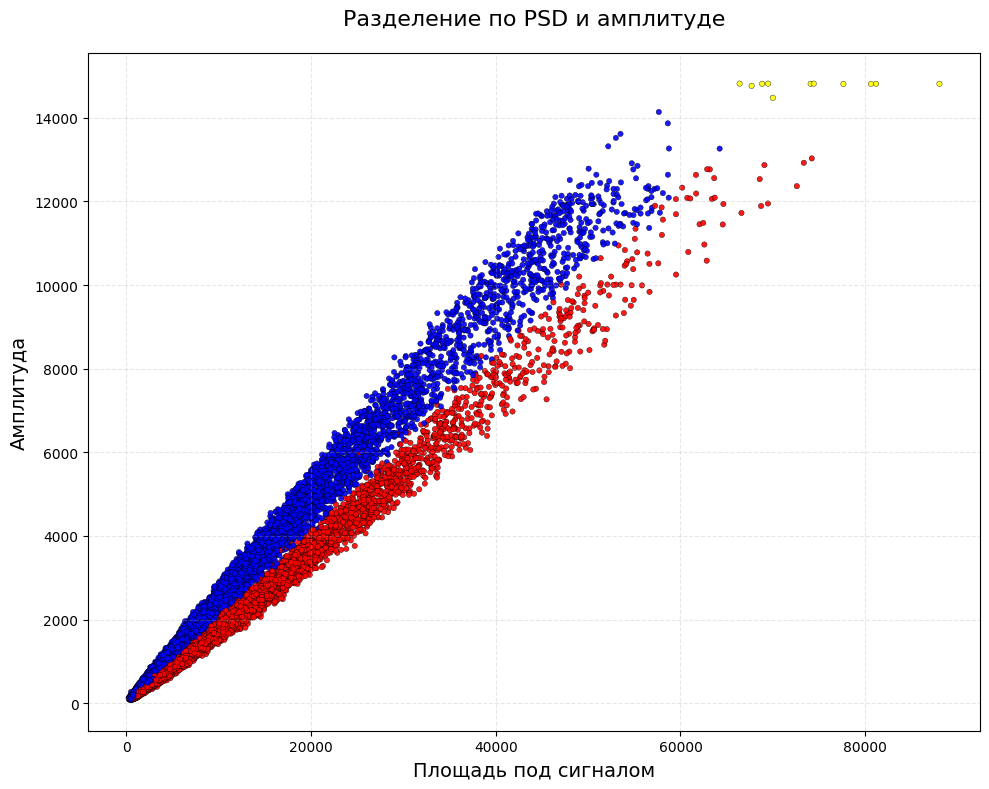

Коэффициент силуэта: 0.005961943378728039
Score на Kaggle: 0.85020


In [10]:
labels = (dataset["psd"] < 0.375).astype(int)

labels[dataset["amplitude"] > 14300] = 2

plt.figure(figsize=(10, 8))
colors = ListedColormap(['red', 'blue', 'yellow'])

scatterplot = plt.scatter(volumes, amplitudes, c=labels, s=15, alpha=0.9, cmap=colors, edgecolors="black", linewidths=0.3)

plt.xlabel("Площадь под сигналом", fontsize=14)
plt.ylabel("Амплитуда", fontsize=14)
plt.title("Разделение по PSD и амплитуде",
          fontsize=16, pad=20)

plt.grid(True, alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

print(f"Коэффициент силуэта: {silhouette_score(X_for_silhouette, labels)}")
print("Score на Kaggle: 0.85020")

results = pd.DataFrame({
    'index': range(len(dataset)),
    'cluster': labels
}).sort_values(by="cluster", kind="stable")
results.to_csv('clusters_2.csv', index=False)

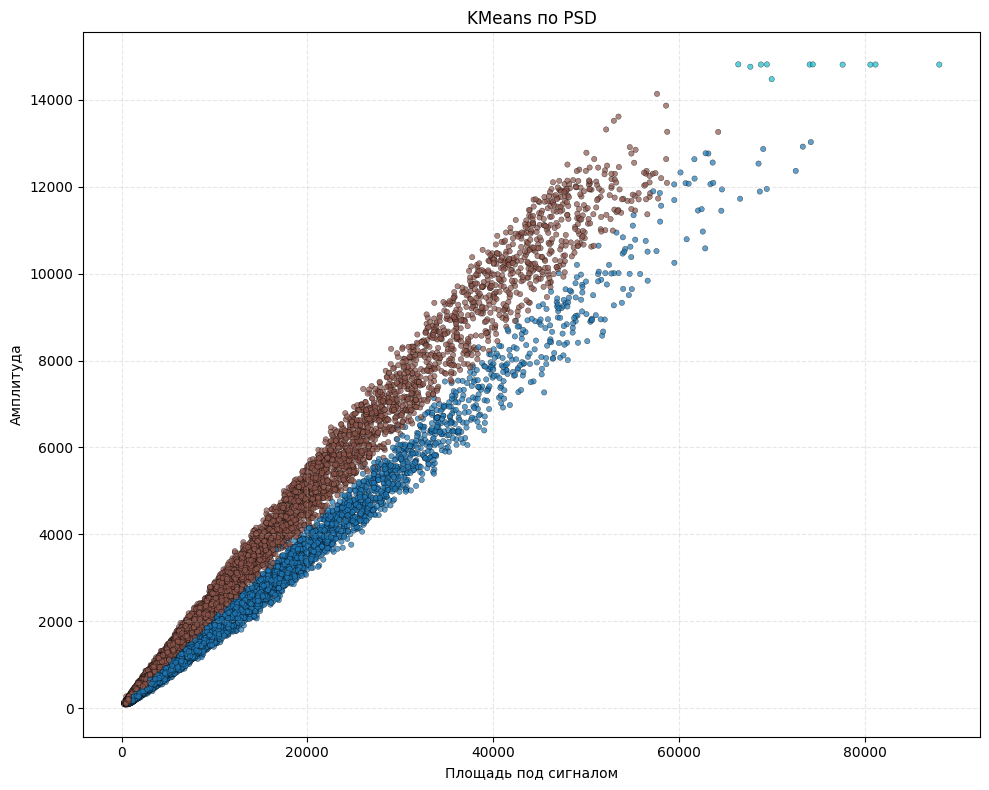

Коэффициент силуэта: 0.0025657865797704595
Score на Kaggle: 0.84211


In [11]:
scaler = StandardScaler()
X_psd = scaler.fit_transform(psd_values[~np.isnan(psd_values)].reshape(-1, 1))

kmeans_psd = KMeans(n_clusters=2, random_state=42, n_init=10)
psd_labels = np.full(len(psd_values), -1)
valid_indices = ~np.isnan(psd_values)

psd_labels[valid_indices] = 1 - kmeans_psd.fit_predict(X_psd)

psd_labels[amplitudes > 14300] = 2

plt.figure(figsize=(10, 8))
plt.scatter(volumes, amplitudes, c=psd_labels, s=15, alpha=0.7, cmap="tab10", edgecolors="black", linewidths=0.3)
plt.xlabel("Площадь под сигналом")
plt.ylabel("Амплитуда")
plt.title("KMeans по PSD")
plt.grid(True, alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

print(f"Коэффициент силуэта: {silhouette_score(X_for_silhouette, psd_labels)}")
print("Score на Kaggle: 0.84211")

results = pd.DataFrame({
    'index': range(len(dataset)),
    'cluster': psd_labels
}).sort_values(by="cluster", kind="stable")
results.to_csv('clusters_3.csv', index=False)


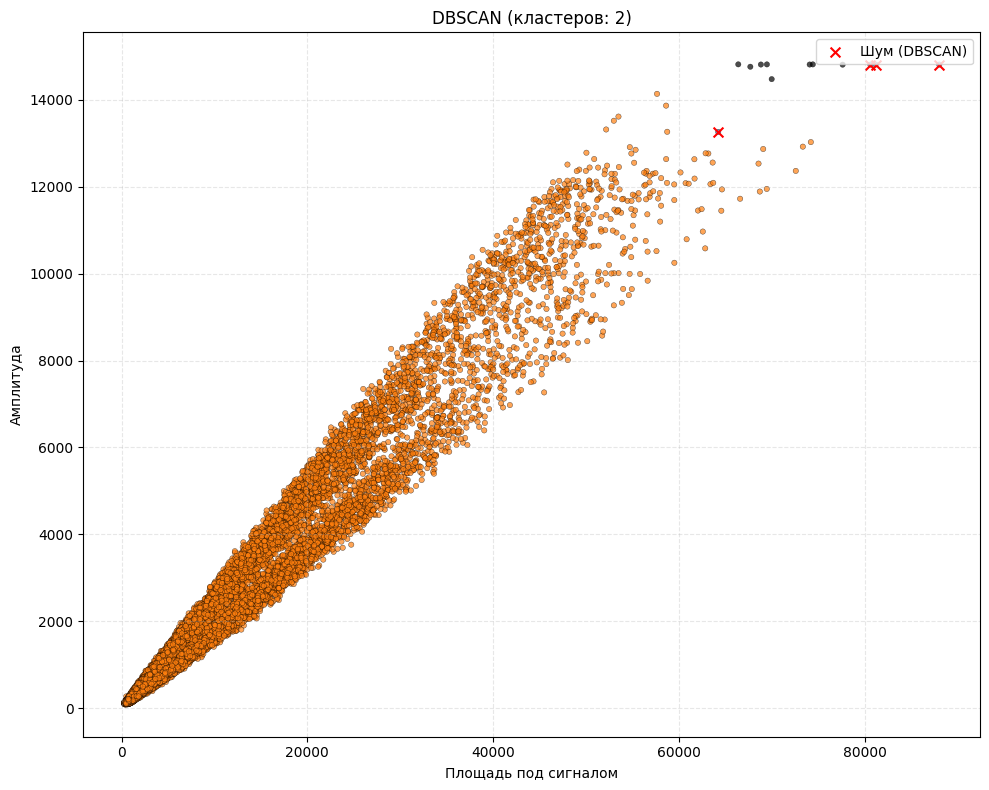

In [16]:
X = dataset[["volume", "amplitude", "psd"]].values
X_scaled = scaler.fit_transform(X)

dbscan = DBSCAN(eps=0.5, min_samples=6)
clusters = dbscan.fit_predict(X_scaled)

plt.figure(figsize=(10, 8))
plt.scatter(volumes, amplitudes,
            c=clusters,
            s=15,
            alpha=0.7,
            cmap=colors,
            edgecolors="black",
            linewidths=0.3)

noise_mask = clusters == -1
if np.any(noise_mask):
    plt.scatter(volumes[noise_mask], amplitudes[noise_mask],
                c='red', s=50, marker='x', label='Шум (DBSCAN)')

plt.xlabel("Площадь под сигналом")
plt.ylabel("Амплитуда")
plt.title(f"DBSCAN (кластеров: {len(np.unique(clusters[clusters != -1]))})")
plt.legend()
plt.grid(True, alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

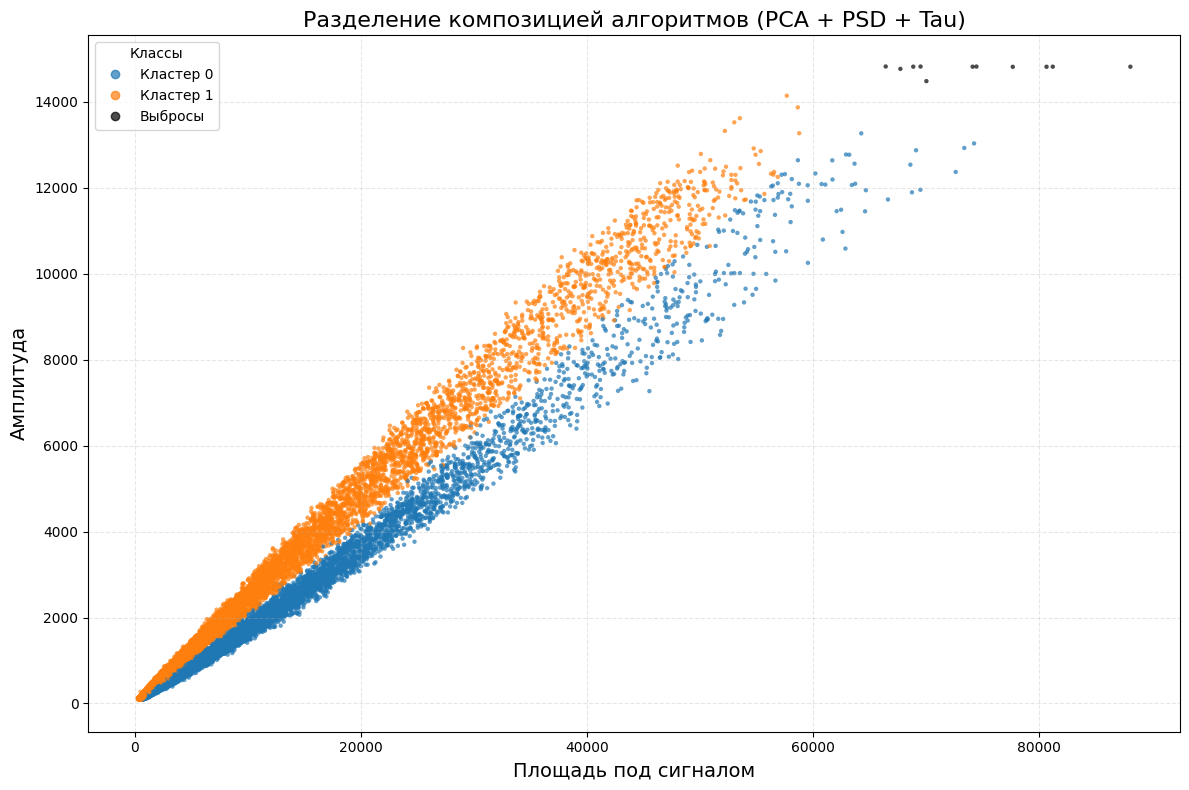

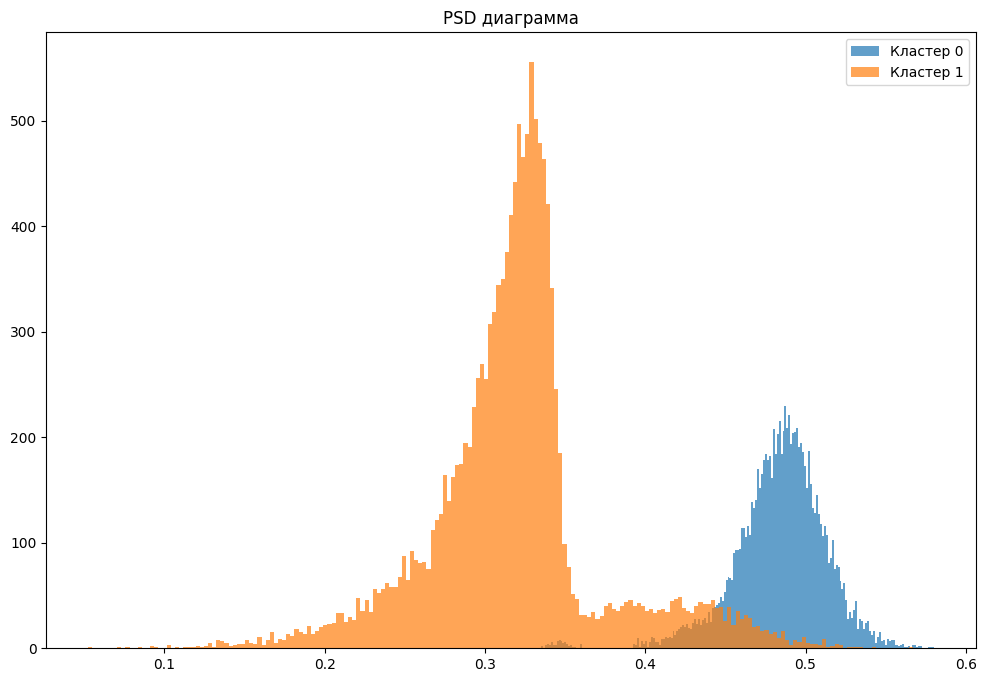

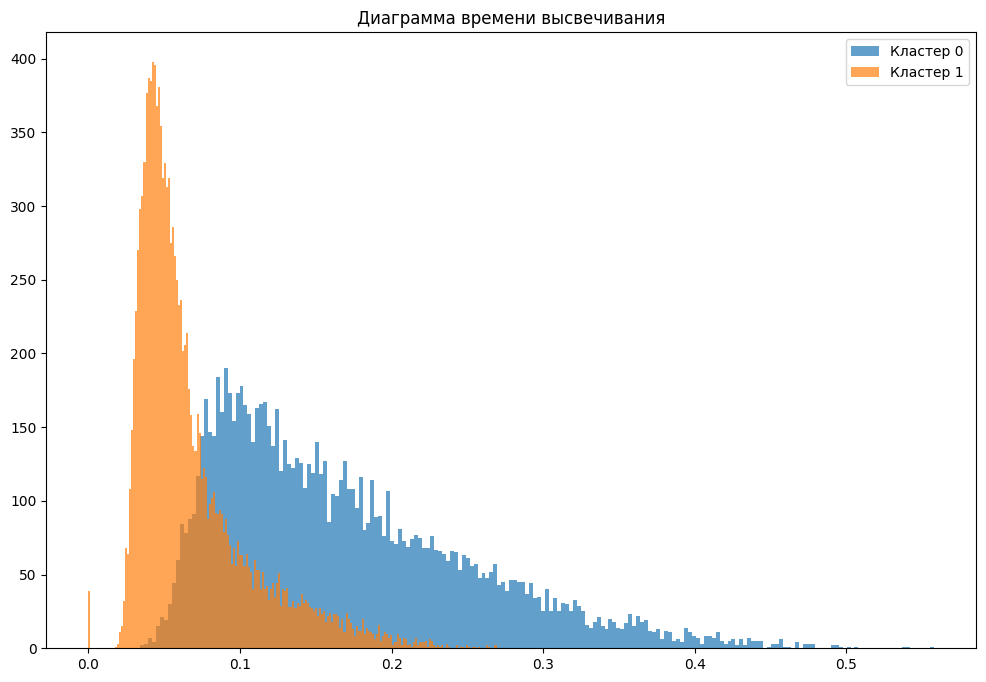

Коэффициент силуэта: 0.019811214573498017
Score на Kaggle: 0.79079


In [17]:
valid_idx = ~np.isnan(psd_values) & ~np.isnan(tau_values) & (volumes > 0)
dataset_clean = pd.DataFrame({
    'volume': volumes[valid_idx],
    'amplitude': amplitudes[valid_idx],
    'psd': psd_values[valid_idx],
    'tau': tau_values[valid_idx] / 100.0
})

X_pca_input = dataset_clean[["volume", "amplitude"]].values
pca = PCA(n_components=1)
X_proj = pca.fit_transform(X_pca_input)
center = X_pca_input.mean(axis=0)
pc1 = pca.components_[0]
vectors = X_pca_input - center
cross_prod = vectors[:, 0] * pc1[1] - vectors[:, 1] * pc1[0]
labels_pca = (cross_prod > 0).astype(int)

kmeans_psd = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_psd = kmeans_psd.fit_predict(dataset_clean[['psd']])

kmeans_tau = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_tau = kmeans_tau.fit_predict(dataset_clean[['tau']])


def align_labels(labels, psd_ref):
    mean_psd_0 = np.mean(psd_ref[labels == 0])
    mean_psd_1 = np.mean(psd_ref[labels == 1])
    
    if mean_psd_0 > mean_psd_1:
        return 1 - labels
    return labels

labels_pca_aligned = align_labels(labels_pca, dataset_clean['psd'])
labels_psd_aligned = align_labels(labels_psd, dataset_clean['psd'])
labels_tau_aligned = align_labels(labels_tau, dataset_clean['psd'])

votes_sum = labels_pca_aligned + labels_psd_aligned + labels_tau_aligned
final_labels = (votes_sum >= 2).astype(int)

final_labels = 1 - final_labels
outlier_mask = dataset_clean['amplitude'] > 14300
final_labels[outlier_mask] = 2

plt.figure(figsize=(12, 8))
colors = ListedColormap(['tab:blue', 'tab:orange', 'black'])
scatter = plt.scatter(dataset_clean['volume'], dataset_clean['amplitude'],
            c=final_labels,
            s=10,
            alpha=0.7,
            cmap=colors,
            edgecolors='none')

plt.xlabel("Площадь под сигналом", fontsize=14)
plt.ylabel("Амплитуда", fontsize=14)
plt.title("Разделение композицией алгоритмов (PCA + PSD + Tau)", fontsize=16)

# Легенда
classes = ['Кластер 0', 'Кластер 1', 'Выбросы']
handles, _ = scatter.legend_elements()
plt.legend(handles, classes, title="Классы")

plt.grid(True, alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
plt.hist(dataset_clean['psd'][final_labels==0], bins=200, alpha=0.7, label='Кластер 0', color='tab:blue')
plt.hist(dataset_clean['psd'][final_labels==1], bins=200, alpha=0.7, label='Кластер 1', color='tab:orange')
plt.title('PSD диаграмма')
plt.legend()

plt.figure(figsize=(12, 8))
plt.hist(dataset_clean['tau'][final_labels==0], bins=200, alpha=0.7, label='Кластер 0', color='tab:blue')
plt.hist(dataset_clean['tau'][final_labels==1], bins=200, alpha=0.7, label='Кластер 1', color='tab:orange')
plt.title('Диаграмма времени высвечивания')
plt.legend()


plt.show()

print(f"Коэффициент силуэта: {silhouette_score(X_for_silhouette, final_labels)}")
print("Score на Kaggle: 0.79079")

results = pd.DataFrame({
    'index': range(len(dataset)),
    'cluster': final_labels
}).sort_values(by="cluster", kind="stable")
results.to_csv('clusters_4.csv', index=False)